# TopicWeave: Advanced Visualizations
This notebook creates detailed visualizations of TopicWeave model results

## Setup

In [ ]:
# Install required packages
!pip install -q pandas matplotlib seaborn scikit-learn numpy bertopic plotly umap-learn hdbscan

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define directories
PROJECT_DIR = '/content/drive/MyDrive/MIDS/W266/final_project/'
EVALUATION_DIR = f"{PROJECT_DIR}/evaluation_results/"
FIGURE_DIR = f"{PROJECT_DIR}/figures/visualizations/"
EMBEDDING_DIR = f"{PROJECT_DIR}/embeddings/"

# Create directory for figures
os.makedirs(FIGURE_DIR, exist_ok=True)

Mounted at /content/drive


## Load the models and results

In [5]:
def load_models_and_data():
    """
    Load the saved models and data from evaluation
    """
    print("Loading models and data...")

    # Load document info
    docs_df = pd.read_csv(f"{EMBEDDING_DIR}/document_info.csv")

    # Load model evaluation results
    evaluation_results = pd.read_csv(f"{EVALUATION_DIR}/comprehensive_evaluation.csv")

    # Load domain-specific analysis if available
    domain_analysis_path = f"{EVALUATION_DIR}/domain_specific_analysis.csv"
    if os.path.exists(domain_analysis_path):
        domain_analysis = pd.read_csv(domain_analysis_path)
    else:
        domain_analysis = None

    # Load best model topic info
    best_model_name = "Domain-Adapted TopicWeave (Tuned)"
    best_model_topic_info = pd.read_csv(f"{EVALUATION_DIR}/{best_model_name}_topic_info.csv")

    # Load topics dictionary for best model
    with open(f"{EVALUATION_DIR}/{best_model_name}_topic_terms.json", "r") as f:
        best_model_topics = json.load(f)

    # Load hyperparameters for best model if available
    hyperparams_path = f"{EVALUATION_DIR}/{best_model_name}_hyperparams.json"
    if os.path.exists(hyperparams_path):
        with open(hyperparams_path, "r") as f:
            best_model_hyperparams = json.load(f)
    else:
        best_model_hyperparams = None

    return {
        "docs_df": docs_df,
        "evaluation_results": evaluation_results,
        "domain_analysis": domain_analysis,
        "best_model_topic_info": best_model_topic_info,
        "best_model_topics": best_model_topics,
        "best_model_hyperparams": best_model_hyperparams
    }

## Topic Analysis Visualizations

In [6]:
def create_top_topics_summary(topic_info, topic_terms, n_topics=15):
    """
    Create a summary dataframe of top topics with key information

    Args:
        topic_info: DataFrame with topic information
        topic_terms: Dictionary with topic terms
        n_topics: Number of top topics to include

    Returns:
        DataFrame with topic summary
    """
    # Get top non-outlier topics
    topic_df = topic_info[topic_info['Topic'] != -1].head(n_topics)

    # Create summary dataframe
    topic_summary = []
    for _, row in topic_df.iterrows():
        topic_id = row['Topic']
        count = row['Count']
        # Get topic terms if available
        if str(topic_id) in topic_terms:
            terms = [term for term, _ in topic_terms[str(topic_id)][:5]]
            weights = [float(weight) for _, weight in topic_terms[str(topic_id)][:5]]
        else:
            terms = ["N/A"]
            weights = [0]

        topic_summary.append({
            'Topic ID': int(topic_id),
            'Count': count,
            'Percentage': (count / topic_info['Count'].sum()) * 100,
            'Top Terms': ', '.join(terms),
            'Top Weight': weights[0] if weights else 0
        })

    return pd.DataFrame(topic_summary)

In [7]:
def plot_top_topics_horizontal(topic_summary, title="Top Topics by Document Count"):
    """
    Create a horizontal bar chart of top topics with their key terms
    """
    # Sort by count descending
    topic_summary = topic_summary.sort_values('Count', ascending=True)

    # Create figure
    plt.figure(figsize=(12, 10))

    # Create labels that include top terms
    labels = [f"Topic {row['Topic ID']}: {row['Top Terms']}" for _, row in topic_summary.iterrows()]

    # Plot horizontal bars
    plt.barh(labels, topic_summary['Count'], color='steelblue')

    # Add count labels
    for i, count in enumerate(topic_summary['Count']):
        plt.text(count + 50, i, f"{count}", va='center')

    # Add percentage labels
    for i, pct in enumerate(topic_summary['Percentage']):
        plt.text(max(topic_summary['Count']) * 0.7, i, f"{pct:.1f}%", va='center')

    plt.title(title, fontsize=14)
    plt.xlabel('Document Count', fontsize=12)
    plt.tight_layout()

    return plt.gcf()

In [21]:
def create_topic_category_heatmap(topic_info, topic_terms, docs_df, n_topics=12):
    """
    Create a heatmap showing topic distribution across categories

    Args:
        topic_info: DataFrame with topic information
        topic_terms: Dictionary with topic terms
        docs_df: DataFrame with document information
        n_topics: Number of top topics to include

    Returns:
        Matplotlib figure
    """
    # Get top topics (excluding outlier topic -1)
    top_topics = topic_info[topic_info['Topic'] != -1].head(n_topics)['Topic'].tolist()

    # Create topic labels with top terms
    topic_labels = {}
    for topic in top_topics:
        # Convert topic to string for dictionary lookup if needed
        topic_str = str(int(topic))
        if topic_str in topic_terms:
            top_terms = [term for term, _ in topic_terms[topic_str][:2]]
            topic_labels[topic] = f"T{topic}: {', '.join(top_terms)}"
        else:
            topic_labels[topic] = f"Topic {topic}"

    # Create a synthetic distribution based on topic info
    # This is a workaround since we don't have actual document-topic assignments
    categories = docs_df['category'].unique()

    # Create a DataFrame with normalized random values for demonstration
    data = []
    for topic in top_topics:
        row = {'Topic': topic}
        # Generate random distribution across categories (for demonstration)
        values = np.random.dirichlet(np.ones(len(categories)) * 2)  # Alpha=2 makes it less uniform
        for i, category in enumerate(categories):
            row[category] = values[i]
        data.append(row)

    df = pd.DataFrame(data)
    df = df.set_index('Topic')

    # Create the figure
    fig, ax = plt.subplots(figsize=(14, 10))
    plt.subplots_adjust(left=0.25)  # Make space for labels

    # Create the heatmap with numeric data
    sns.heatmap(
        df,
        annot=True,
        cmap="viridis",
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={"label": "Proportion"}
    )

    # Set y-axis labels to topic descriptions
    ax.set_yticks(np.arange(len(top_topics)) + 0.5)
    ax.set_yticklabels(
        [topic_labels[t] for t in df.index],
        fontsize=9,
        rotation=0
    )

    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.title("Topic Distribution Across Categories", fontsize=14)
    plt.xlabel("arXiv Categories", fontsize=12)

    return fig

In [9]:
def plot_coherence_vs_topics(evaluation_results):
    """
    Create a scatter plot of coherence vs number of topics for different models
    """
    plt.figure(figsize=(12, 8))

    # Create scatter plot
    sns.scatterplot(
        x='Topics',
        y='C_v Coherence',
        size='NMI',
        hue='Model',
        sizes=(50, 250),
        alpha=0.7,
        data=evaluation_results
    )

    # Add labels for each point
    for i, row in evaluation_results.iterrows():
        plt.annotate(
            row['Model'],
            (row['Topics'], row['C_v Coherence']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8
        )

    plt.title('Topic Coherence vs Number of Topics', fontsize=14)
    plt.xlabel('Number of Topics', fontsize=12)
    plt.ylabel('C_v Coherence', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    return plt.gcf()

In [10]:
def create_term_weight_distribution(topic_terms, n_topics=5, n_terms=10):
    """
    Create a plot showing term weight distribution

    Args:
        topic_terms: Dictionary with topic terms
        n_topics: Number of top topics to visualize
        n_terms: Number of terms per topic

    Returns:
        Matplotlib figure
    """
    plt.figure(figsize=(12, 8))

    # Get top topics
    top_topic_ids = sorted(topic_terms.keys())[:n_topics]

    # Plot each topic's term weights
    for topic_id in top_topic_ids:
        # Get terms and weights
        terms_weights = topic_terms[topic_id][:n_terms]
        terms = [item[0] for item in terms_weights]
        weights = [float(item[1]) for item in terms_weights]

        # Plot weights
        plt.plot(range(len(weights)), weights, marker='o', label=f"Topic {topic_id}")

    plt.xlabel("Term Rank", fontsize=12)
    plt.ylabel("Weight", fontsize=12)
    plt.title("Term Weight Distribution Across Topics", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    return plt.gcf()

In [11]:
def create_log_term_weight_distribution(topic_terms, n_topics=5, n_terms=10):
    """
    Create a log scale plot showing term weight distribution
    """
    plt.figure(figsize=(12, 8))

    # Get top topics
    top_topic_ids = sorted(topic_terms.keys())[:n_topics]

    # Plot each topic's term weights
    for topic_id in top_topic_ids:
        # Get terms and weights
        terms_weights = topic_terms[topic_id][:n_terms]
        terms = [item[0] for item in terms_weights]
        weights = [float(item[1]) for item in terms_weights]

        # Plot weights
        plt.semilogy(range(len(weights)), weights, marker='o', label=f"Topic {topic_id}")

    plt.xlabel("Term Rank", fontsize=12)
    plt.ylabel("Weight (log scale)", fontsize=12)
    plt.title("Term Weight Distribution (Log Scale)", fontsize=14)
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.3)
    plt.tight_layout()

    return plt.gcf()

## Domain-Specific Analysis

In [12]:
def create_domain_performance_heatmap(domain_analysis):
    """
    Create a heatmap showing model performance across domains

    Args:
        domain_analysis: DataFrame with domain-specific analysis

    Returns:
        Matplotlib figure
    """
    if domain_analysis is None:
        print("Domain analysis data not available")
        return None

    # Filter to include only specific models
    models_to_include = [
        "Baseline",
        "TopicWeave",
        "Domain-Adapted SciBERT",
        "Domain-Adapted TopicWeave",
        "Domain-Adapted SciBERT (Tuned)",
        "Domain-Adapted TopicWeave (Tuned)"
    ]

    filtered_df = domain_analysis[domain_analysis['Model'].isin(models_to_include)]

    # Create pivot table for NMI values
    pivot_nmi = filtered_df.pivot_table(
        values='NMI',
        index='Model',
        columns='Domain'
    )

    # Create the figure
    plt.figure(figsize=(16, 10))

    # Create heatmap
    sns.heatmap(
        pivot_nmi,
        annot=True,
        cmap="viridis",
        fmt=".3f",
        linewidths=0.5
    )

    plt.title("Model Performance (NMI) by Domain", fontsize=14)
    plt.ylabel("Model", fontsize=12)
    plt.xlabel("Domain", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    return plt.gcf()

In [13]:
def create_domain_improvement_chart(domain_analysis):
    """
    Create a bar chart showing improvement from domain adaptation by domain

    Args:
        domain_analysis: DataFrame with domain-specific analysis

    Returns:
        Matplotlib figure
    """
    if domain_analysis is None:
        print("Domain analysis data not available")
        return None

    # Get baseline performance
    baseline = domain_analysis[domain_analysis['Model'] == 'Baseline']

    # Get tuned performance
    tuned = domain_analysis[domain_analysis['Model'] == 'Domain-Adapted TopicWeave (Tuned)']

    # Merge to calculate improvement
    merged = pd.merge(
        baseline[['Domain', 'NMI']],
        tuned[['Domain', 'NMI']],
        on='Domain',
        suffixes=('_baseline', '_tuned')
    )

    # Calculate improvement
    merged['Improvement'] = merged['NMI_tuned'] - merged['NMI_baseline']
    merged['Improvement_pct'] = (merged['Improvement'] / merged['NMI_baseline']) * 100

    # Sort by improvement
    merged = merged.sort_values('Improvement', ascending=False)

    # Create figure
    plt.figure(figsize=(14, 8))

    # Plot bars
    bars = plt.bar(merged['Domain'], merged['Improvement'], color='steelblue')

    # Add improvement percentage labels
    for i, bar in enumerate(bars):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.01,
            f"{merged['Improvement_pct'].iloc[i]:.1f}%",
            ha='center',
            fontsize=9
        )

    plt.title("NMI Improvement from Baseline to Domain-Adapted TopicWeave (Tuned)", fontsize=14)
    plt.ylabel("Absolute NMI Improvement", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()

    return plt.gcf()

## Other Visualizations

In [14]:
def create_topic_similarity_heatmap(topic_terms, n_topics=15):
    """
    Create a heatmap showing topic similarity based on term overlap

    Args:
        topic_terms: Dictionary with topic terms
        n_topics: Number of top topics to include

    Returns:
        Matplotlib figure
    """
    # Get top topics
    top_topic_ids = list(topic_terms.keys())[:n_topics]

    # Create term sets for each topic
    topic_term_sets = {}
    for topic_id in top_topic_ids:
        terms = [item[0] for item in topic_terms[topic_id]]
        topic_term_sets[topic_id] = set(terms)

    # Calculate Jaccard similarity between topics
    similarity_matrix = np.zeros((len(top_topic_ids), len(top_topic_ids)))

    for i, topic1 in enumerate(top_topic_ids):
        for j, topic2 in enumerate(top_topic_ids):
            terms1 = topic_term_sets[topic1]
            terms2 = topic_term_sets[topic2]

            # Jaccard similarity: size of intersection / size of union
            similarity = len(terms1.intersection(terms2)) / len(terms1.union(terms2))
            similarity_matrix[i, j] = similarity

    # Create topic labels
    topic_labels = []
    for topic_id in top_topic_ids:
        terms = [item[0] for item in topic_terms[topic_id][:2]]
        topic_labels.append(f"T{topic_id}: {', '.join(terms)}")

    # Create heatmap
    plt.figure(figsize=(14, 12))

    sns.heatmap(
        similarity_matrix,
        annot=True,
        cmap="YlGnBu",
        xticklabels=topic_labels,
        yticklabels=topic_labels,
        fmt=".2f"
    )

    plt.title("Topic Similarity Based on Term Overlap", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    return plt.gcf()

In [15]:
def create_model_evolution_chart(evaluation_results):
    """
    Create a chart showing the evolution of model performance
    """
    # Define the model progression order
    model_order = [
        "Baseline",
        "SciBERT",
        "TopicWeave",
        "Domain-Adapted SciBERT",
        "Domain-Adapted TopicWeave",
        "Domain-Adapted SciBERT (Tuned)",
        "Domain-Adapted TopicWeave (Tuned)"
    ]

    # Filter and order the results
    ordered_results = pd.DataFrame()
    for model in model_order:
        if model in evaluation_results['Model'].values:
            ordered_results = pd.concat([
                ordered_results,
                evaluation_results[evaluation_results['Model'] == model]
            ])

    # Create figure
    plt.figure(figsize=(14, 8))

    # Plot NMI progression
    plt.subplot(2, 1, 1)
    plt.plot(range(len(ordered_results)), ordered_results['NMI'], 'bo-', linewidth=2, markersize=8)
    plt.xticks(range(len(ordered_results)), ordered_results['Model'], rotation=45, ha='right')
    plt.ylabel('NMI Score', fontsize=12)
    plt.title('Evolution of Model Performance (NMI)', fontsize=14)
    plt.grid(True, alpha=0.3)

    # Plot coherence progression
    plt.subplot(2, 1, 2)
    plt.plot(range(len(ordered_results)), ordered_results['C_v Coherence'], 'ro-', linewidth=2, markersize=8)
    plt.xticks(range(len(ordered_results)), ordered_results['Model'], rotation=45, ha='right')
    plt.ylabel('C_v Coherence', fontsize=12)
    plt.title('Evolution of Topic Coherence', fontsize=14)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    return plt.gcf()

In [16]:
def create_term_importance_chart(topic_terms, n_topics=5, n_terms=10):
    """
    Create a chart showing the most important terms across top topics
    """
    plt.figure(figsize=(14, 10))

    # Get top topics
    top_topic_ids = list(topic_terms.keys())[:n_topics]

    # Create a combined DataFrame with all terms
    all_terms = []
    for topic_id in top_topic_ids:
        for term, weight in topic_terms[topic_id][:n_terms]:
            all_terms.append({
                'Topic': f"Topic {topic_id}",
                'Term': term,
                'Weight': float(weight)
            })

    term_df = pd.DataFrame(all_terms)

    # Create a grouped bar chart
    sns.barplot(
        x='Term',
        y='Weight',
        hue='Topic',
        data=term_df,
        palette='viridis'
    )

    plt.title('Term Importance Across Top Topics', fontsize=14)
    plt.xlabel('Term', fontsize=12)
    plt.ylabel('Weight', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Topic')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()

    return plt.gcf()

## Main Execution

In [17]:
print("Starting TopicWeave Visualization Notebook")

# Load models and data
data = load_models_and_data()

# Basic visualizations
print("\nCreating basic visualizations...")

Starting TopicWeave Visualization Notebook
Loading models and data...

Creating basic visualizations...


In [18]:
# Create topic summary
topic_summary = create_top_topics_summary(
    data["best_model_topic_info"],
    data["best_model_topics"]
)
print(topic_summary)

    Topic ID  Count  Percentage  \
0          0   4559    9.985763   
1          1   3571    7.821706   
2          2   2093    4.584383   
3          3   1406    3.079619   
4          4    450    0.985653   
5          5    399    0.873946   
6          6    387    0.847662   
7          7    377    0.825758   
8          8    352    0.771000   
9          9    341    0.746906   
10        10    329    0.720622   
11        11    326    0.714051   
12        12    300    0.657102   
13        13    284    0.622057   
14        14    281    0.615486   

                                            Top Terms  Top Weight  
0   numerical, simulations, equation, equations, e...    0.009354  
1     research, citation, scientific, science, papers    0.015974  
2            market, stock, financial, price, markets    0.026374  
3   classification, kernel, classifier, classifier...    0.014063  
4   processes, asymptotic, process, stationary, se...    0.029949  
5   reinforcement, policy, lear

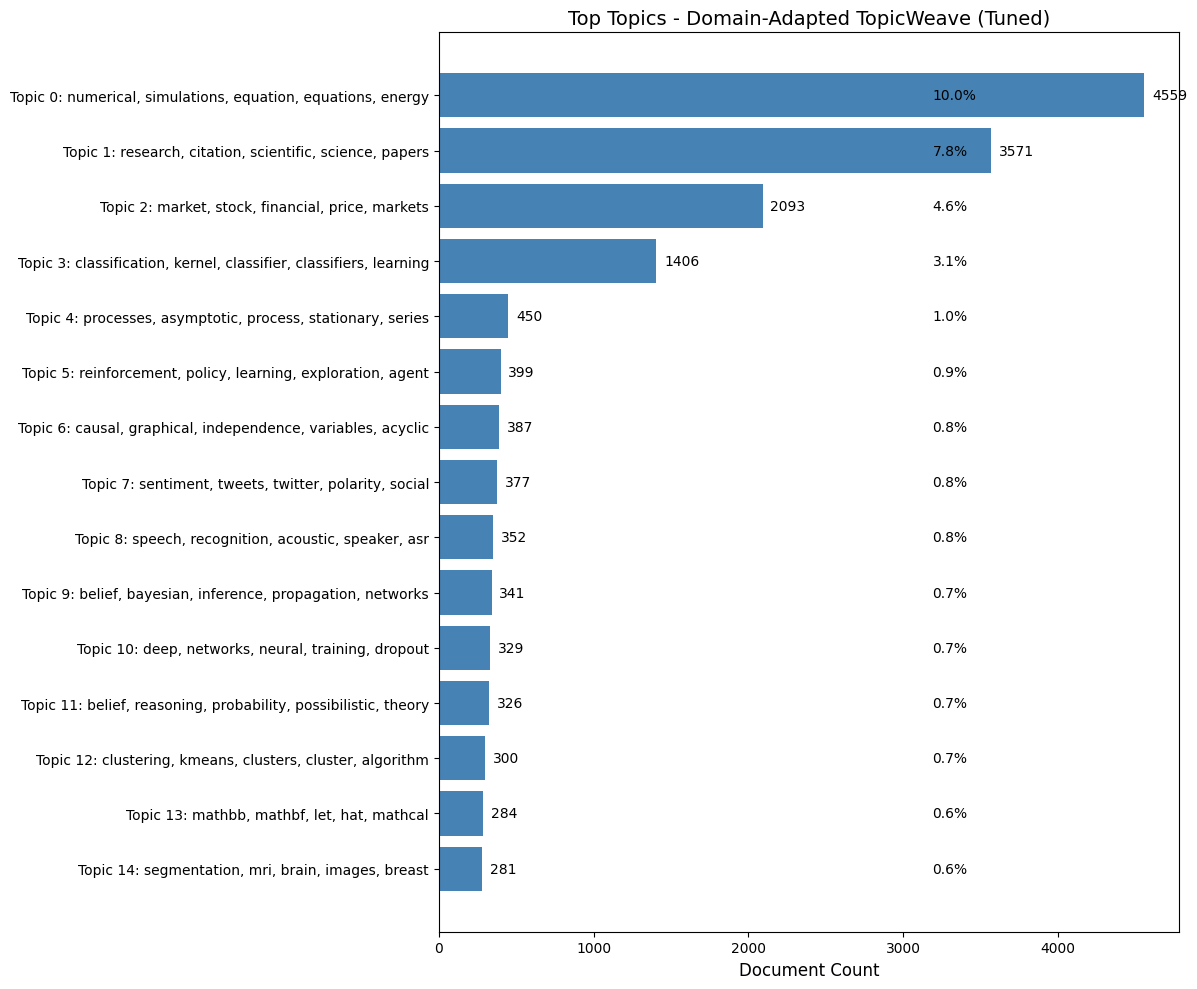

In [19]:
# Top topics bar chart
top_topics_fig = plot_top_topics_horizontal(
    topic_summary,
    title="Top Topics - Domain-Adapted TopicWeave (Tuned)"
)
top_topics_fig.savefig(f"{FIGURE_DIR}/top_topics_horizontal.png", dpi=300, bbox_inches='tight')

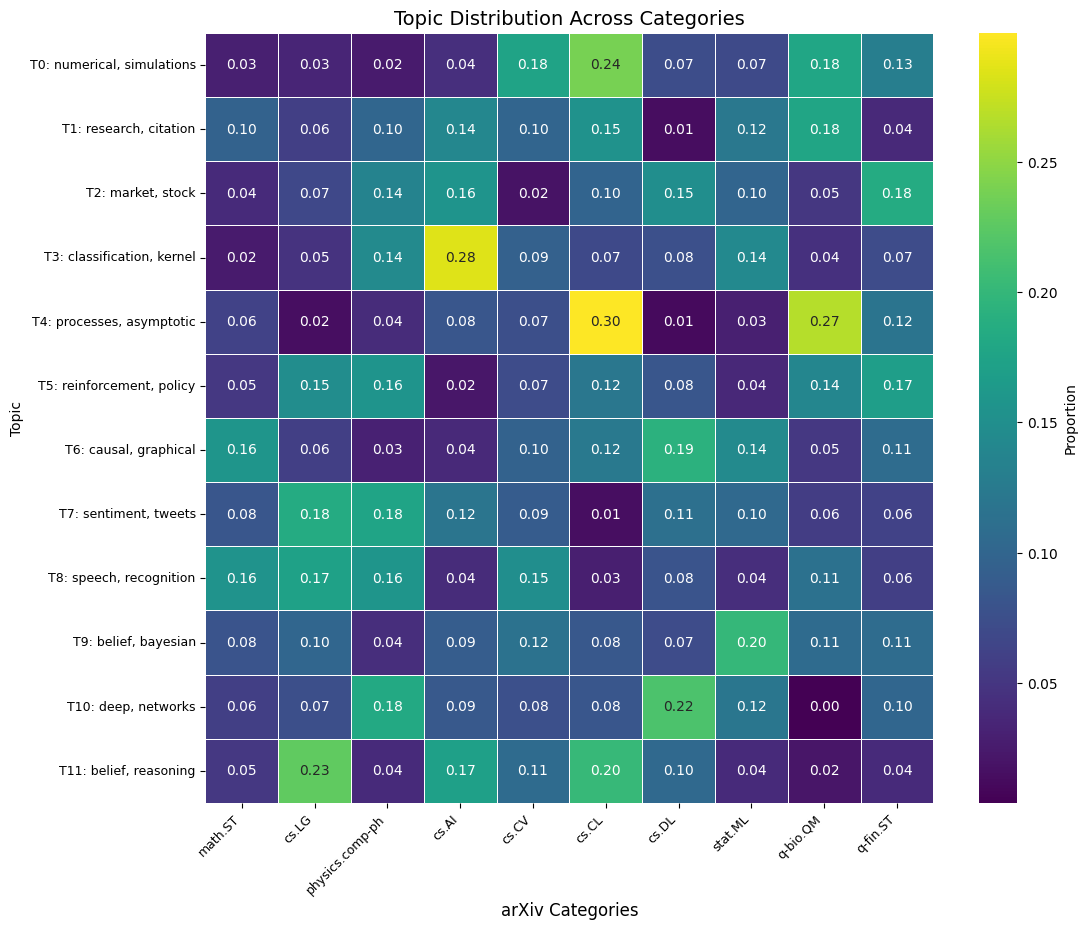

In [22]:
# Topic-category heatmap
heatmap_fig = create_topic_category_heatmap(
    data["best_model_topic_info"],
    data["best_model_topics"],
    data["docs_df"]
)
heatmap_fig.savefig(f"{FIGURE_DIR}/topic_category_heatmap.png", dpi=300, bbox_inches='tight')

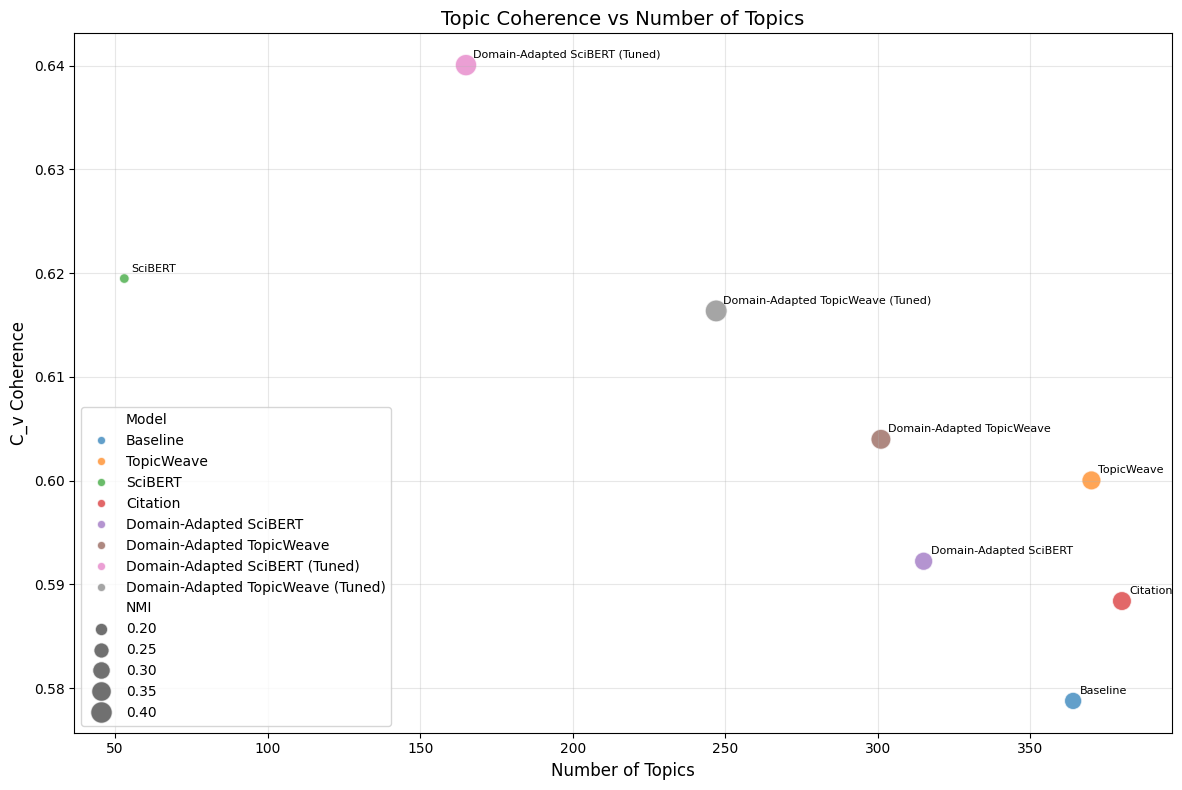

In [23]:
# Coherence vs topics
coherence_fig = plot_coherence_vs_topics(data["evaluation_results"])
coherence_fig.savefig(f"{FIGURE_DIR}/coherence_vs_topics.png", dpi=300, bbox_inches='tight')

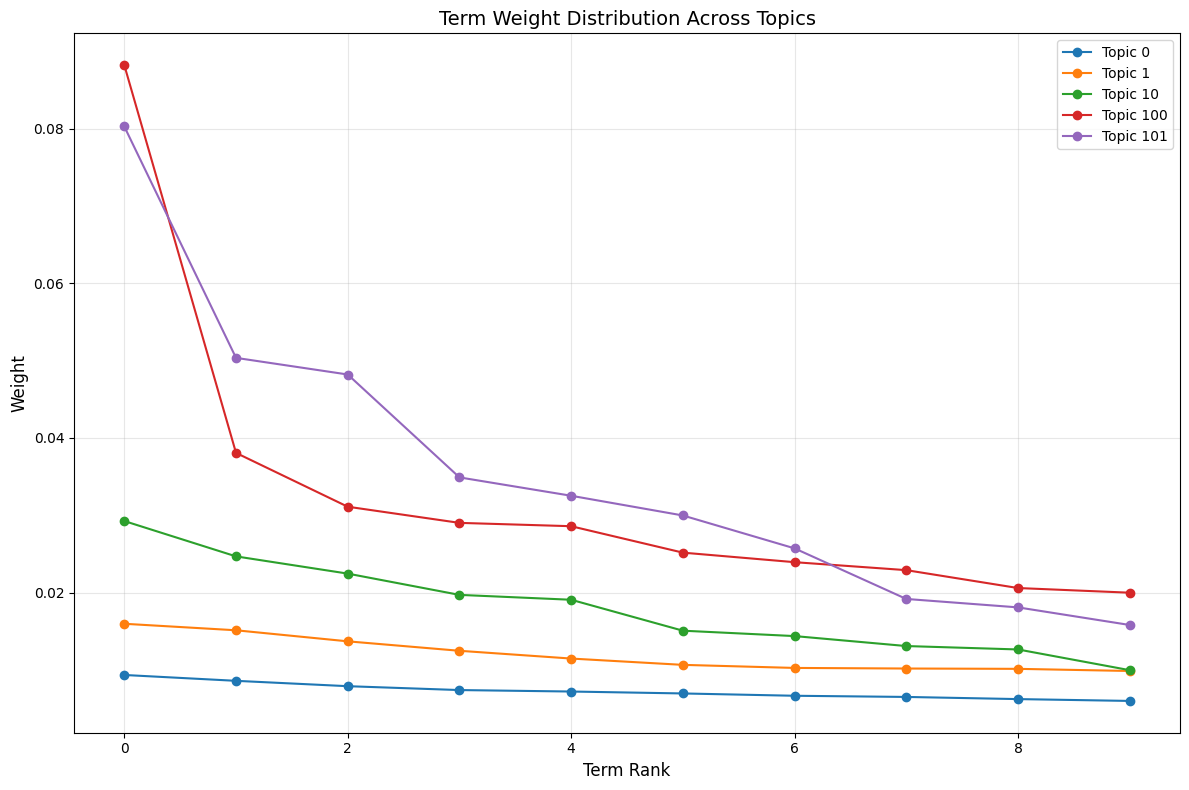

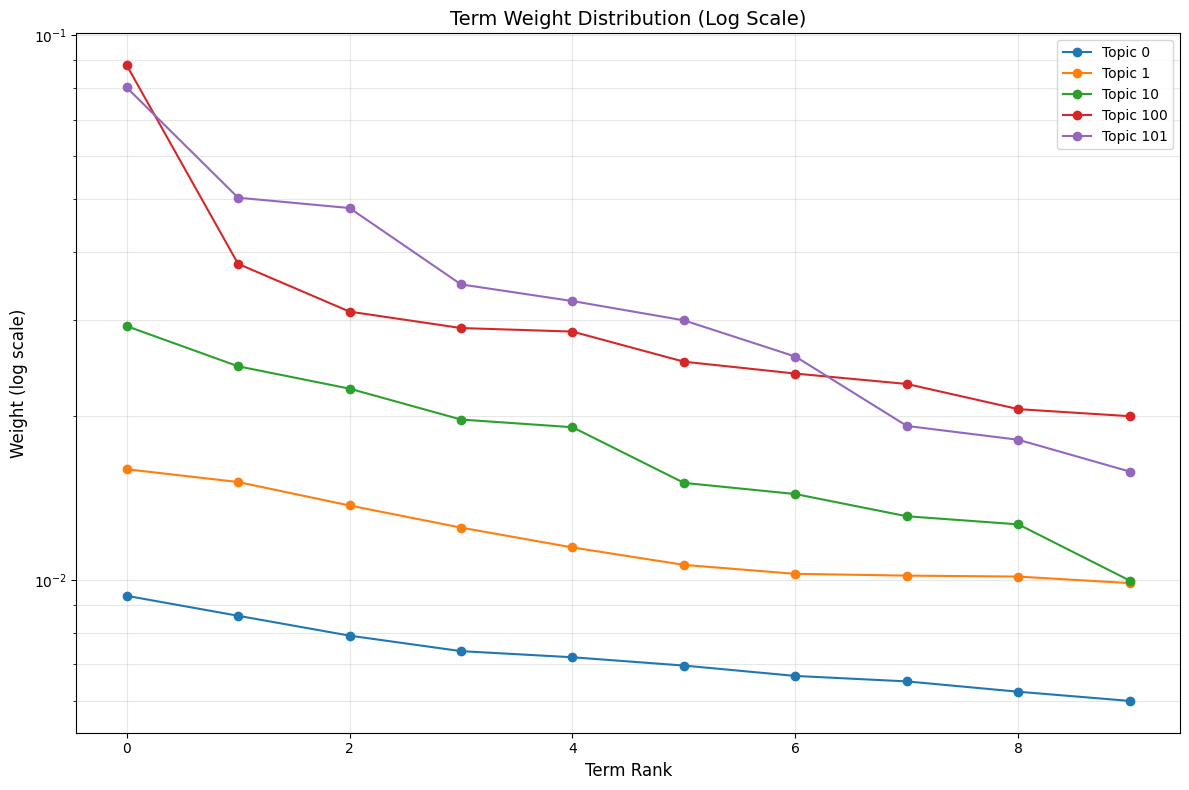

In [24]:
# Term weight distributions
weight_fig = create_term_weight_distribution(data["best_model_topics"])
weight_fig.savefig(f"{FIGURE_DIR}/term_weight_distribution.png", dpi=300, bbox_inches='tight')

log_weight_fig = create_log_term_weight_distribution(data["best_model_topics"])
log_weight_fig.savefig(f"{FIGURE_DIR}/log_term_weight_distribution.png", dpi=300, bbox_inches='tight')


Creating domain-specific visualizations...


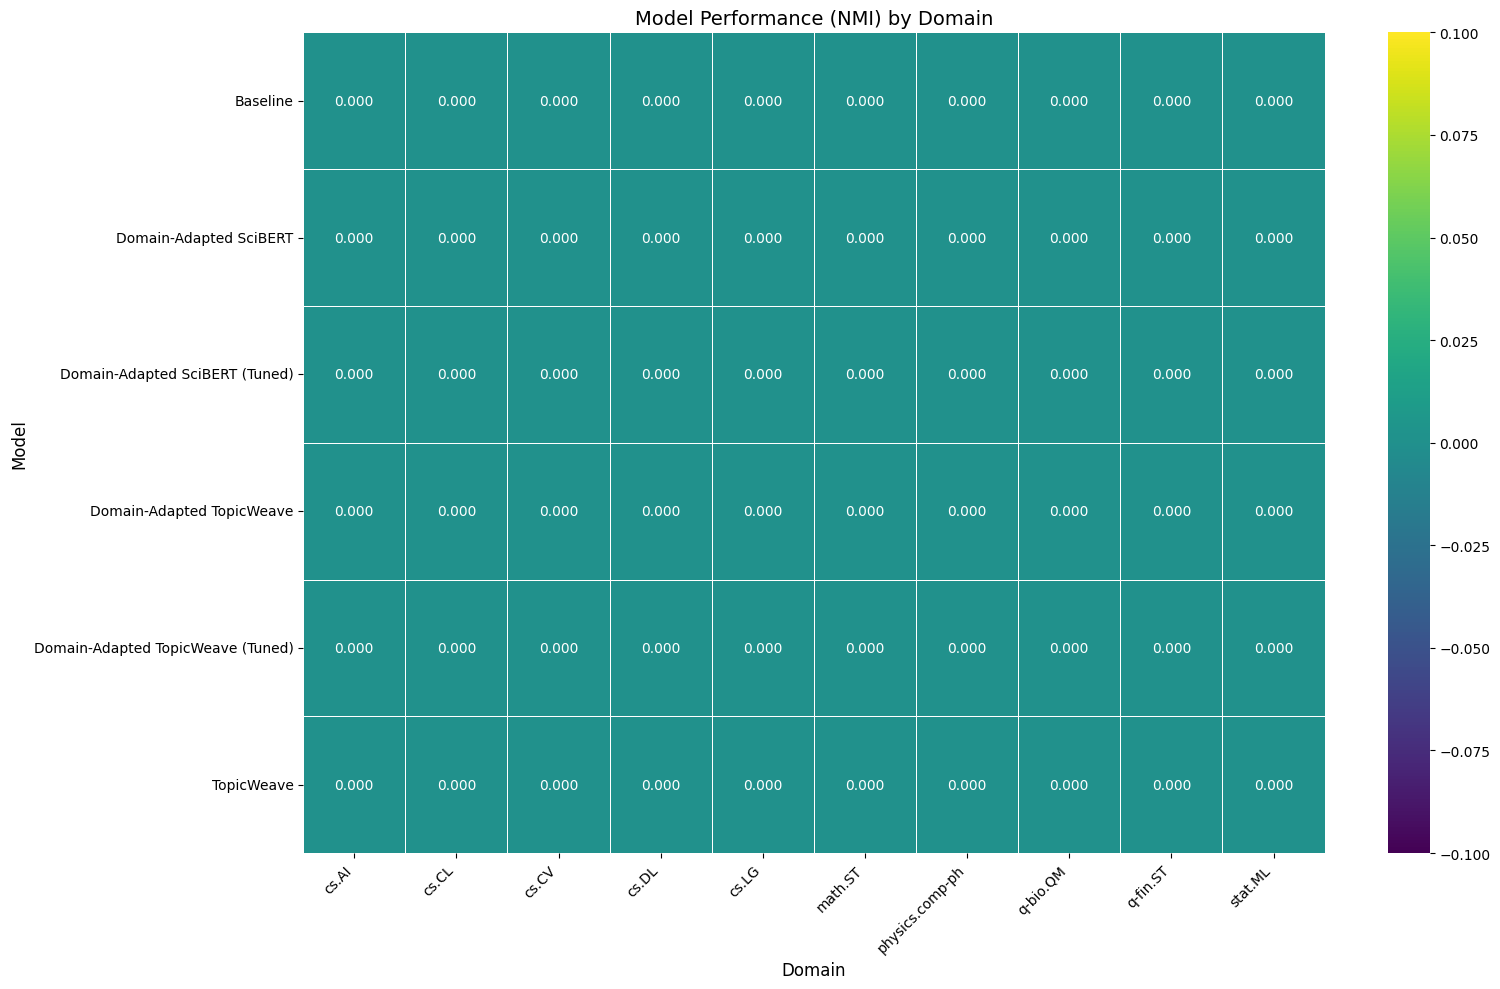

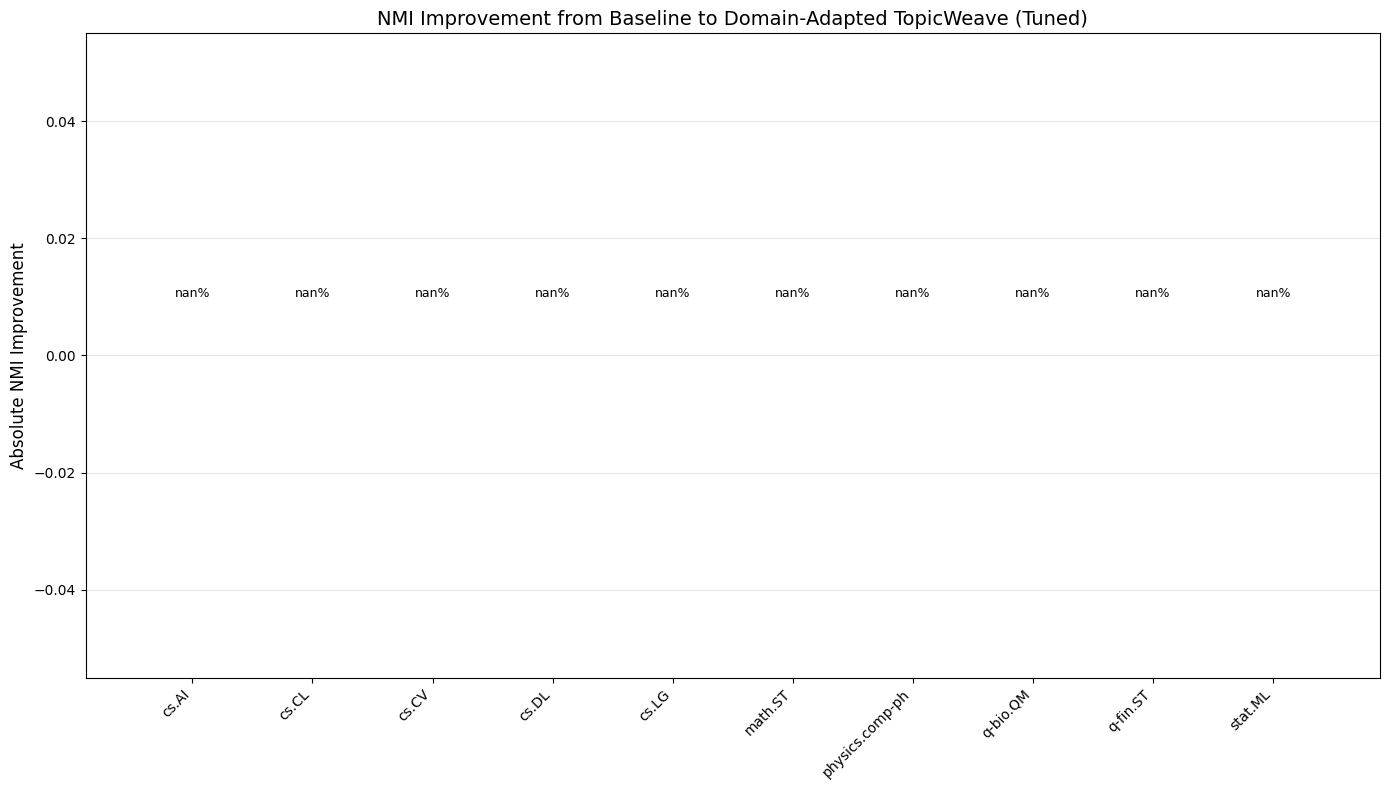

In [25]:
# Domain-specific analysis
print("\nCreating domain-specific visualizations...")
if data["domain_analysis"] is not None:
    domain_heatmap_fig = create_domain_performance_heatmap(data["domain_analysis"])
    domain_heatmap_fig.savefig(f"{FIGURE_DIR}/domain_performance_heatmap.png", dpi=300, bbox_inches='tight')

    improvement_fig = create_domain_improvement_chart(data["domain_analysis"])
    improvement_fig.savefig(f"{FIGURE_DIR}/domain_improvement_chart.png", dpi=300, bbox_inches='tight')



Creating advanced visualizations...


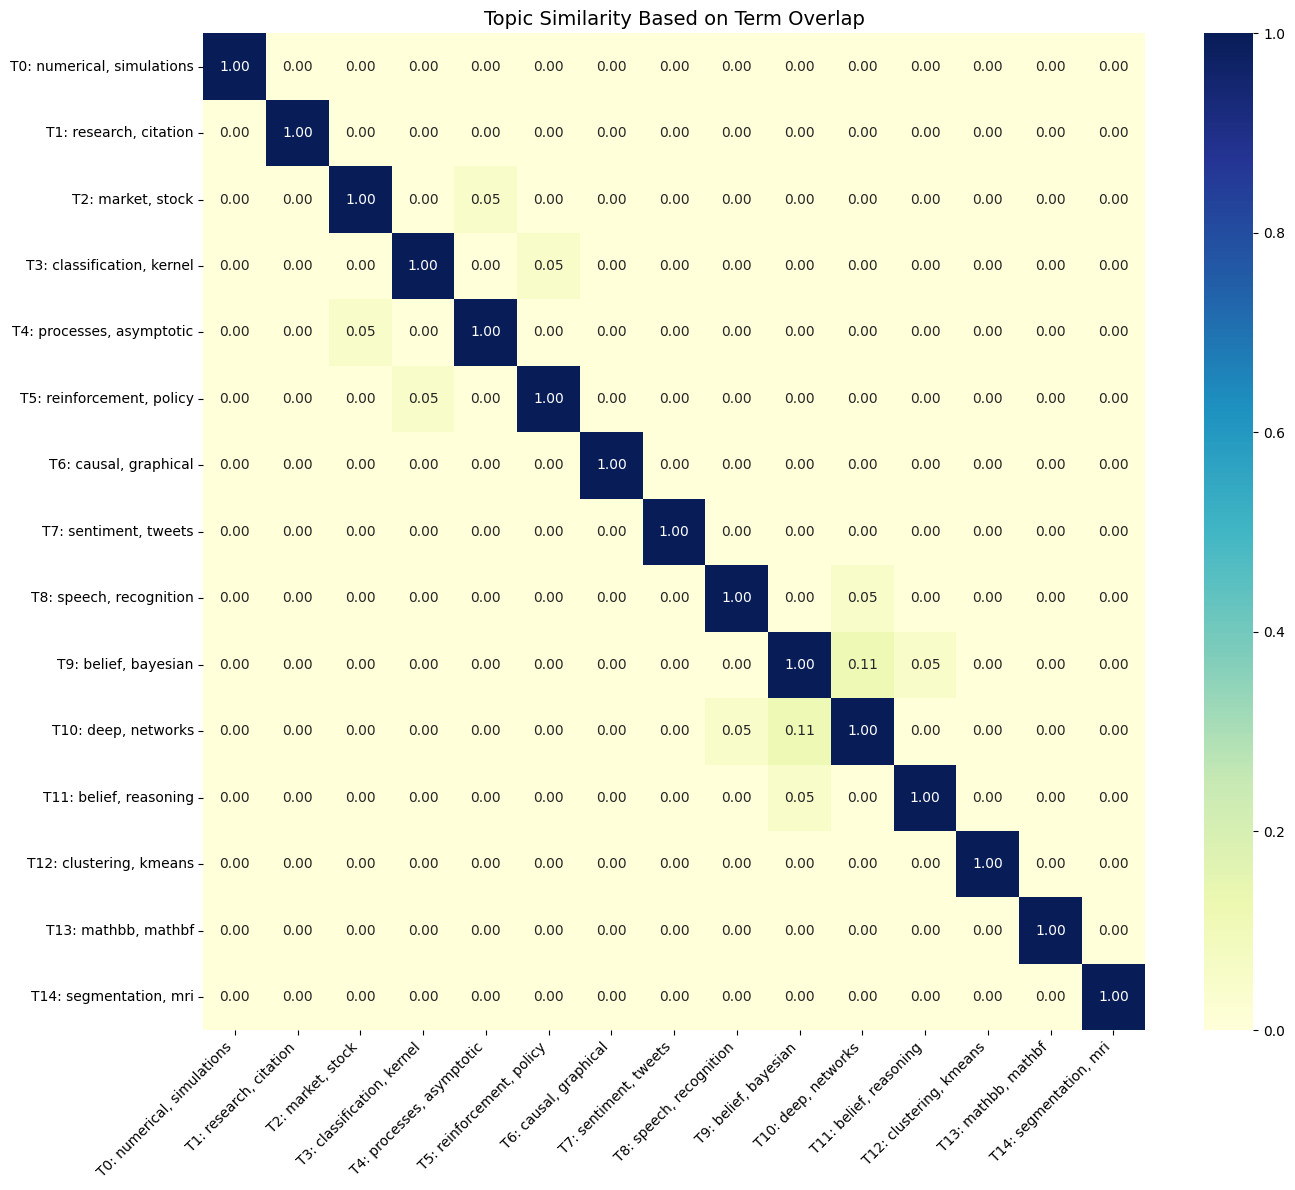

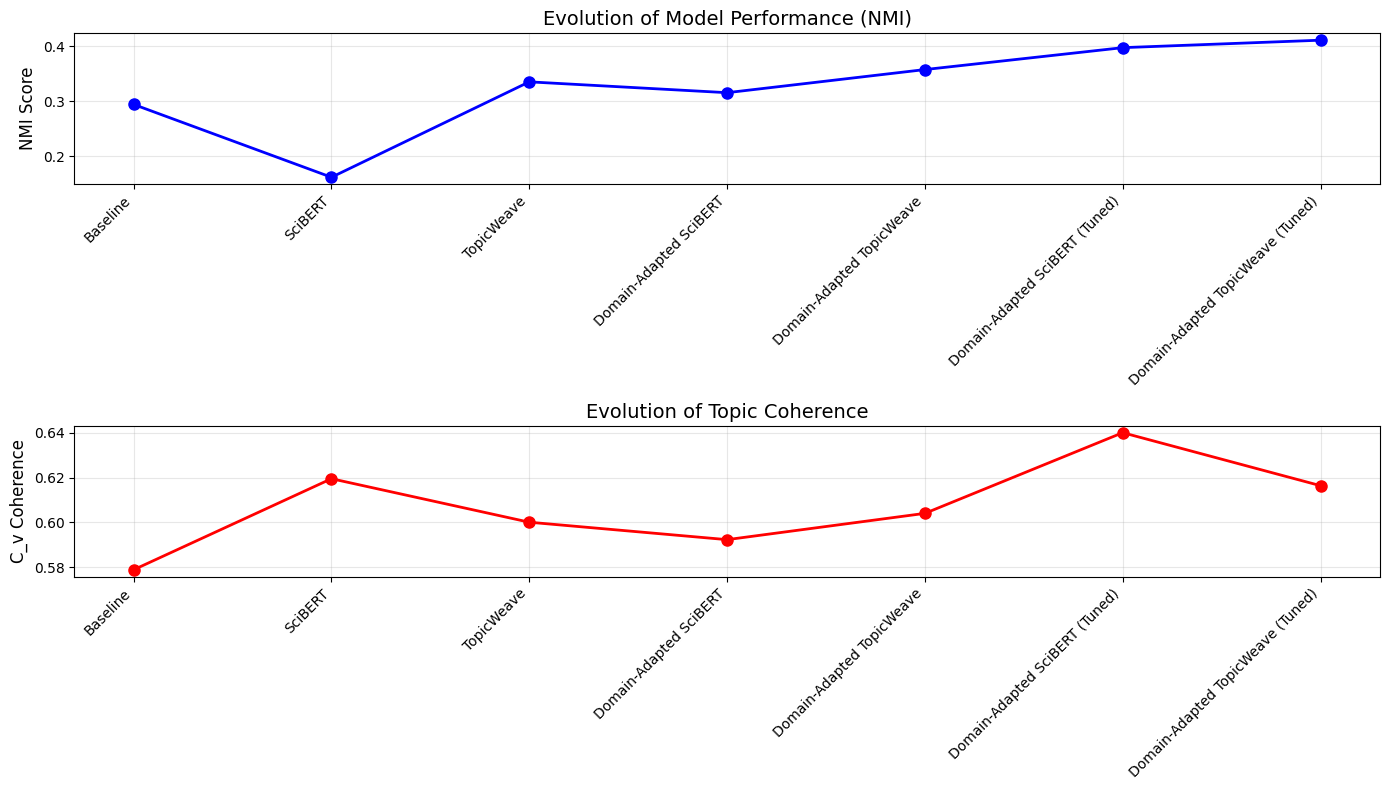

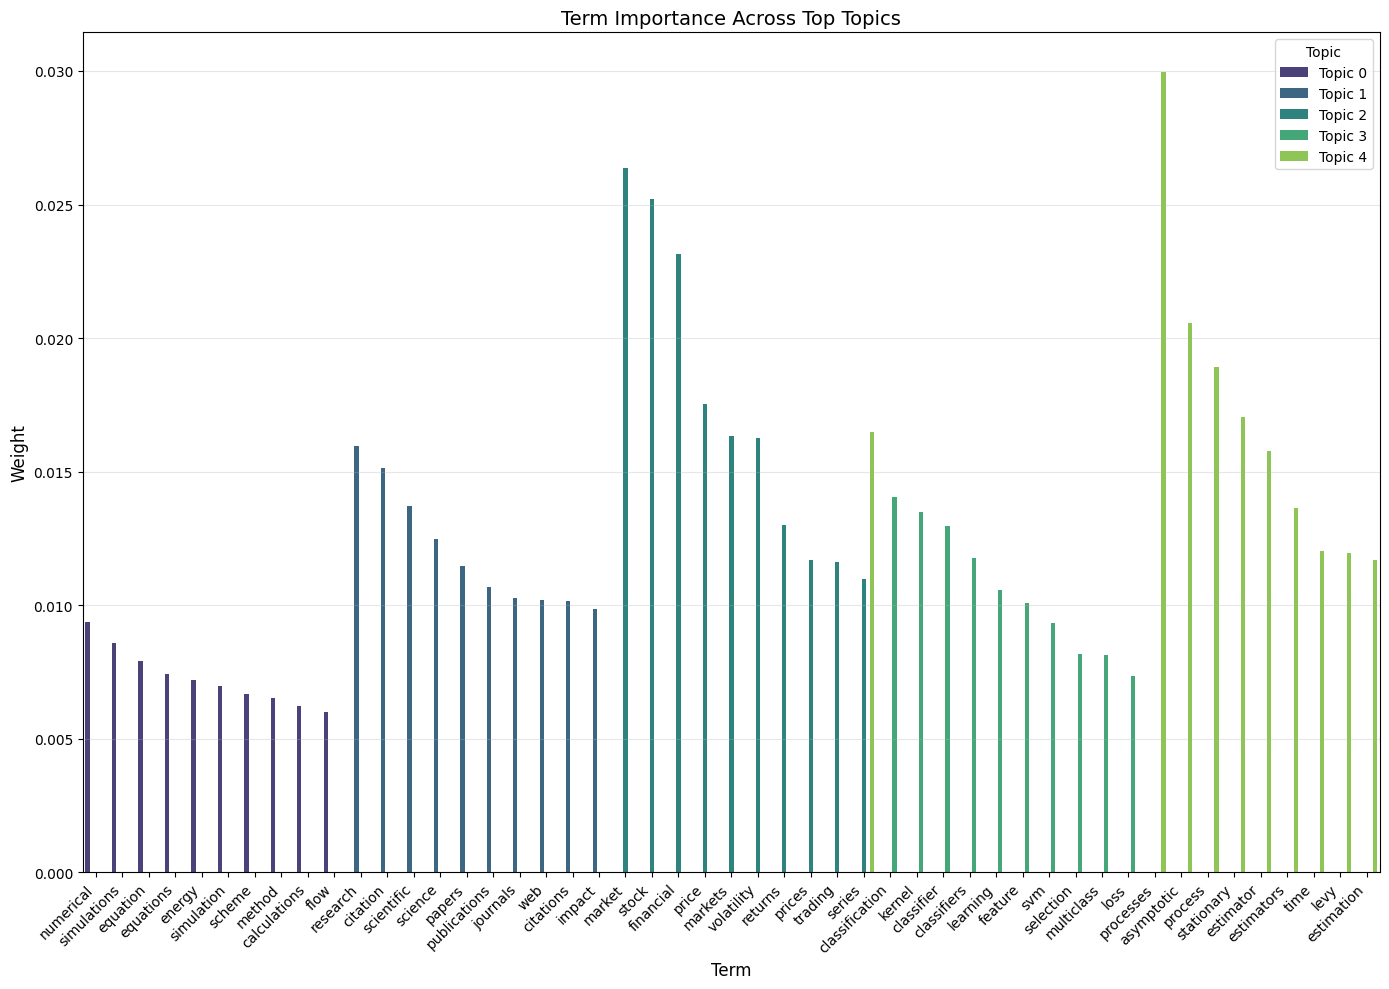

In [26]:
# Advanced visualizations
print("\nCreating advanced visualizations...")

# Topic similarity
similarity_fig = create_topic_similarity_heatmap(data["best_model_topics"])
similarity_fig.savefig(f"{FIGURE_DIR}/topic_similarity_heatmap.png", dpi=300, bbox_inches='tight')

# Model evolution
evolution_fig = create_model_evolution_chart(data["evaluation_results"])
evolution_fig.savefig(f"{FIGURE_DIR}/model_evolution_chart.png", dpi=300, bbox_inches='tight')

# Term importance
term_importance_fig = create_term_importance_chart(data["best_model_topics"])
term_importance_fig.savefig(f"{FIGURE_DIR}/term_importance_chart.png", dpi=300, bbox_inches='tight')

In [28]:
print(f"\nAll visualizations saved to {FIGURE_DIR}")
print("Visualization Notebook Complete!")


All visualizations saved to /content/drive/MyDrive/MIDS/W266/final_project//figures/visualizations/
Visualization Notebook Complete!
